In [ ]:
# load
# print
## param

In [1]:
#import all

import os
import os.path as osp
import yaml
import argparse
import dill
import pdb
import time
import math
import random
import pickle

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.nn.functional as F
import torch.distributions.multivariate_normal as torchdist
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils import data
from torch.autograd import Variable
from torch.nn import Module, Parameter, ModuleList, Linear

from tensorboardX import SummaryWriter
from tqdm.auto import tqdm
from easydict import EasyDict

import datetime, shutil, argparse, logging, sys
 
from dataset.preprocessing import get_node_timestep_data, collate 


In [59]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--run_file',type=str, default='rein10.py')
    parser.add_argument('--config_file',type=str, default='./configs/baseline.yaml')

    parser.add_argument('--folder_date',type=str, default='read')
    parser.add_argument('--dataset',type=str, default='eth')
    parser.add_argument('--exp',type=str, default='rein10-test1')

    parser.add_argument('--read', default=True, type=bool)
    parser.add_argument('--model',type=str, default='/home/yaoliu/scratch/experiment/rein/test-0808-02/eth/baseline/95_model.pt')

    parser.add_argument("--batch_size", default=256, type=int)
    parser.add_argument("--eval_batch_size", default=256, type=int)
    parser.add_argument('--shuffle', default=True, type=bool)
    parser.add_argument("--eval_every", default=10, type=int)

    parser.add_argument("--num_steps", default=100, type=int)
    parser.add_argument("--num_ddim", default=10, type=int)
    parser.add_argument("--ddim_eta", default=0.0, type=float)
    parser.add_argument("--clip_denoised", default=False, type=bool)

    parser.add_argument("--loss_diffusion_rate", default=10., type=float)
    parser.add_argument("--loss_gau_rate", default=10000., type=float)
    parser.add_argument("--loss_mean_rate", default=10., type=float)
    parser.add_argument("--loss_left_gau", default=10., type=float)
    parser.add_argument("--lr", default=0.001, type=float)
    parser.add_argument("--lr2", default=0.001, type=float)

    parser.add_argument("--diffusion_sample_num", default=1, type=int)
    parser.add_argument("--point_dim", default=2, type=int)
    parser.add_argument("--pred_length", default=1, type=int)
    parser.add_argument("--end_list", default=20, type=int)
    parser.add_argument("--sample", default=20, type=int)

    parser.add_argument("--device", default=7, type=int)
    parser.add_argument("--isseed", default=True, type=bool)
    parser.add_argument('--seed', default=113, type=int)

    parser.add_argument('--gamma', default=0.95, type=float)
    parser.add_argument("--epochs", default=100, type=int)
    parser.add_argument("--augment", default=True, type=bool)

    parser.add_argument('--data_dir',type=str, default='./processed_data_new')    
    parser.add_argument('--gpu_deterministic', default=False, type=bool, help='set cudnn in deterministic mode (slow)')


    return parser.parse_args(args=[])

In [60]:
def get_traj_hypers():
    hypers = { 
    'state':
        {'PEDESTRIAN':
            {'position': ['x', 'y'],
             'velocity': ['x', 'y'],
             'acceleration': ['x', 'y']
            }
        },
    'pred_state': {'PEDESTRIAN': {'velocity': ['x', 'y']}},
    'edge_encoding': True,
    'edge_addition_filter': [0.25, 0.5, 0.75, 1.0],
    'edge_removal_filter': [1.0, 0.0],
    'dynamic_edges': 'yes',
    'incl_robot_node': False,
    'node_freq_mult_train': False,
    'node_freq_mult_eval': False,
    'scene_freq_mult_train': False,
    'scene_freq_mult_eval': False,
    'scene_freq_mult_viz': False,
    'use_map_encoding': False,
    }
    return hypers


# common function
def set_gpu(gpu):
    torch.cuda.set_device('cuda:{}'.format(gpu))

def set_cuda(deterministic=True):
    if torch.cuda.is_available():
        if not deterministic:
            torch.backends.cudnn.deterministic = False
            torch.backends.cudnn.benchmark = True
        else:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False


def get_output_dir(folder,dataset,exp):
    output_dir = os.path.join('/home/yaoliu/scratch/experiment/rein/' + folder, dataset, exp)
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def setup_logging(name, output_dir, console=True):
    log_format = logging.Formatter("%(asctime)s : %(message)s")
    logger = logging.getLogger(name)
    logger.handlers = []
    output_file = os.path.join(output_dir, 'output.log')
    file_handler = logging.FileHandler(output_file)
    file_handler.setFormatter(log_format)
    logger.addHandler(file_handler)
    if console:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(log_format)
        logger.addHandler(console_handler)
    logger.setLevel(logging.INFO)
    return logger

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

def copy_source(file, output_dir):
    shutil.copyfile(file, os.path.join(output_dir, os.path.basename(file)))

def restore(data):
    """
    In case we dilled some structures to share between multiple process this function will restore them.
    If the data input are not bytes we assume it was not dilled in the first place

    :param data: Possibly dilled data structure
    :return: Un-dilled data structure
    """
    if type(data) is bytes:
        return dill.loads(data)
    return data


# data function
class EnvironmentDataset(object):
    def __init__(self, env, state, pred_state, node_freq_mult, scene_freq_mult, hyperparams, **kwargs):
        self.env = env
        self.state = state
        self.pred_state = pred_state
        self.hyperparams = hyperparams
        self.max_ht = 7 # 7
        self.max_ft = 12
        self.node_type_datasets = list() # 1-->1670
        self._augment = False
        for node_type in env.NodeType:
            if node_type not in hyperparams['pred_state']:
                continue
            self.node_type_datasets.append(NodeTypeDataset(env, node_type, state, pred_state, node_freq_mult,
                                                           scene_freq_mult, hyperparams, **kwargs))

    @property
    def augment(self):
        return self._augment

    @augment.setter
    def augment(self, value):
        self._augment = value
        for node_type_dataset in self.node_type_datasets:
            node_type_dataset.augment = value

    def __iter__(self):
        return iter(self.node_type_datasets)


class NodeTypeDataset(data.Dataset):
    def __init__(self, env, node_type, state, pred_state, node_freq_mult,
                 scene_freq_mult, hyperparams, augment=False, **kwargs):
        self.env = env
        self.state = state
        '''
        {'PEDESTRIAN': {'position': ['x', 'y'],
        'velocity': ['x', 'y'],
        'acceleration': ['x', 'y']}}
        '''
        self.pred_state = pred_state # {'PEDESTRIAN': {'velocity': ['x', 'y']}}
        self.hyperparams = hyperparams
        self.max_ht = 7 # 7
        self.max_ft = 12 #12

        self.augment = augment

        self.node_type = node_type # PEDESTRIAN
        self.index = self.index_env(node_freq_mult, scene_freq_mult, **kwargs)
        self.len = len(self.index) # 1670
        self.edge_types = [edge_type for edge_type in env.get_edge_types() if edge_type[0] is node_type] # [(PEDESTRIAN, PEDESTRIAN)]

    def index_env(self, node_freq_mult, scene_freq_mult, **kwargs): # False False
        index = list()
        for scene in self.env.scenes:
            present_node_dict = scene.present_nodes(np.arange(0, scene.timesteps), type=self.node_type, **kwargs)
            for t, nodes in present_node_dict.items():
                for node in nodes:
                    index += [(scene, t, node)] *\
                             (scene.frequency_multiplier if scene_freq_mult else 1) *\
                             (node.frequency_multiplier if node_freq_mult else 1)

        return index

    def __len__(self):
        return self.len

    def __getitem__(self, i):
        (scene, t, node) = self.index[i]

        if self.augment:
            scene = scene.augment()
            node = scene.get_node_by_id(node.id)

        return get_node_timestep_data(self.env, scene, t, node, self.state, self.pred_state,
                                      self.edge_types, self.max_ht, self.max_ft, self.hyperparams)
    


class VarianceSchedule(Module):

    def __init__(self, num_steps, mode='linear',beta_1=1e-4, beta_T=5e-2, cosine_s=8e-3):
        '''
            num_steps=100,
            beta_T=5e-2,
            mode='linear'
        '''
        super().__init__()
        assert mode in ('linear', 'cosine')
        self.num_steps = num_steps # 100

        self.beta_1 = beta_1 # 1e-4
        self.beta_T = beta_T # 5e-2
        self.mode = mode # 'linear'

        if mode == 'linear':
            betas = torch.linspace(beta_1, beta_T, steps=num_steps)
        elif mode == 'cosine':
            timesteps = (
            torch.arange(num_steps + 1) / num_steps + cosine_s
            )
            alphas = timesteps / (1 + cosine_s) * math.pi / 2
            alphas = torch.cos(alphas).pow(2)
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = betas.clamp(max=0.999)

        betas = torch.cat([torch.zeros([1]), betas], dim=0)     # Padding

        alphas = 1 - betas
        log_alphas = torch.log(alphas)
        for i in range(1, log_alphas.size(0)):  # 1 to T
            log_alphas[i] += log_alphas[i - 1]
        alpha_bars = log_alphas.exp()

        sigmas_flex = torch.sqrt(betas)
        sigmas_inflex = torch.zeros_like(sigmas_flex)
        for i in range(1, sigmas_flex.size(0)):
            sigmas_inflex[i] = ((1 - alpha_bars[i-1]) / (1 - alpha_bars[i])) * betas[i]
        sigmas_inflex = torch.sqrt(sigmas_inflex)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alpha_bars', alpha_bars)
        self.register_buffer('sigmas_flex', sigmas_flex)
        self.register_buffer('sigmas_inflex', sigmas_inflex)

    def uniform_sample_t(self, batch_size):
        ts = np.random.choice(np.arange(1, self.num_steps+1), batch_size)
        return ts.tolist()

    def get_sigmas(self, t, flexibility):
        assert 0 <= flexibility and flexibility <= 1
        sigmas = self.sigmas_flex[t] * flexibility + self.sigmas_inflex[t] * (1 - flexibility)
        return sigmas
    


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.to(t.device).gather(0, t).float()
    out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
    return out

def get_select_fde(selected_end,end):
    # fde=torch.mean(torch.norm((selected_end.view(256, -1, 2) - end.view(256,-1, 2)),dim=2,dim=[0])
    fde=torch.mean((torch.norm((selected_end.view(256, -1, 2) - end.view(256,-1, 2)),dim=2)),dim=0)
    # fde = F.mse_loss(end.contiguous().view(-1, 2), selected_end.contiguous().view(-1, 2), reduction='mean')
    return fde

def get_pred_loss(pred, selected_end, gt):
    # bs,12,5 bs,1,2, bs,12,2
    sx = torch.exp(pred[:, :, 2])  # sx
    sy = torch.exp(pred[:, :, 3])  # sy
    corr = torch.tanh(pred[:, :, 4])  # corr

    cov = torch.zeros(pred.shape[0], pred.shape[1], 2, 2).to('cuda')
    cov[:, :, 0, 0] = sx * sx
    cov[:, :, 0, 1] = corr * sx * sy
    cov[:, :, 1, 0] = corr * sx * sy
    cov[:, :, 1, 1] = sy * sy
    mean = pred[:, :, 0:2]
    mvn = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
    loss_gt = - mvn.log_prob(gt).sum()
    loss_mean = F.mse_loss(mean[:,-1,:].contiguous().view(-1, 2), selected_end.contiguous().view(-1, 2), reduction='mean')
    # loss=loss_gt/args.loss_gau_rate + loss_mean/args.loss_mean_rate

    return loss_gt, loss_mean

def get_pred_de(pred, gt):
    predlist=len(pred)
    kstep_V_pred_ls = []
    gt = gt.permute(1,0,2)*0.4
    pred = pred.permute(1,0,2)

    sx = torch.exp(pred[:, :, 2])  # sx
    sy = torch.exp(pred[:, :, 3])  # sy
    corr = torch.tanh(pred[:, :, 4])  # corr

    cov = torch.zeros(pred.shape[0], pred.shape[1], 2, 2).to('cuda')
    cov[:, :, 0, 0] = sx * sx
    cov[:, :, 0, 1] = corr * sx * sy
    cov[:, :, 1, 0] = corr * sx * sy
    cov[:, :, 1, 1] = sy * sy
    mean = pred[:, :, 0:2]
    mvn = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)

    KSTEPS=args.sample
    for i in range(KSTEPS-1):
        kstep_V_pred_ls.append(torch.cumsum((mvn.sample()*0.4), dim=0))  # cat [12, num_person, 2]
    kstep_V_pred_ls.append(torch.cumsum(mean*0.4, dim=0))
    kstep_V_pred_ls = torch.stack(kstep_V_pred_ls, dim=0) # [KSTEPS, 12, num_person, 2]

    # kstep_V_pred = np.concatenate([traj for traj in kstep_V_pred_ls], axis=1) # [12, KSTEPS * num_person, 2]

    """end of sampling"""

    V_y_rel_to_abs =  torch.cumsum((gt), dim=0) # [12, num_person, 2] speed???)

    ade=torch.mean(torch.min(torch.norm((kstep_V_pred_ls - V_y_rel_to_abs),dim=3),dim=0)[0],dim=[0,1])
    fde=torch.mean(torch.min(torch.norm((kstep_V_pred_ls - V_y_rel_to_abs)[:,-1,:,:],dim=2),dim=0)[0],dim=[0])
    return ade,fde



def find_end(gauss_param_tensor, coordinates_list):
    gauss_param_tensor = gauss_param_tensor[:,0,:]

    sx = torch.exp(gauss_param_tensor[:, 2])  # sx
    sy = torch.exp(gauss_param_tensor[:, 3])  # sy
    corr = torch.tanh(gauss_param_tensor[:, 4])  # corr
    cov = torch.zeros(gauss_param_tensor.shape[0], 2, 2).to('cuda')
    cov[:, 0, 0] = sx * sx
    cov[:, 0, 1] = corr * sx * sy
    cov[:, 1, 0] = corr * sx * sy
    cov[:, 1, 1] = sy * sy
    mean = gauss_param_tensor[:, 0:2] # bs,1,2
    # 创建MultivariateNormal分布对象
    gauss_distribution = MultivariateNormal(mean, cov)

    # 用来存储每个item的采样概率
    sampling_probs = []

    # 计算每个item与第一个tensor的采样概率
    for coordinates_tensor in coordinates_list:

        # 计算该item在第一个分布下的log概率之和
        log_prob_sum = gauss_distribution.log_prob(coordinates_tensor).sum()

        # 将采样概率存储到列表中
        sampling_probs.append(log_prob_sum)

    # 找到具有最大采样概率的item的索引
    max_prob_index = torch.argmax(torch.tensor(sampling_probs))

    # 选取最有可能是由第一个tensor采样得到的item
    selected_tensor = coordinates_list[max_prob_index]
    selected_sampling_probs= sampling_probs[max_prob_index]

    return selected_tensor, selected_sampling_probs


# main args
args = parse_args()
hyperparams = get_traj_hypers()


# main output-log  

output_dir = get_output_dir(args.folder_date, args.dataset, args.exp)
copy_source(args.run_file, output_dir)
copy_source(args.config_file, output_dir)


set_gpu(args.device)
set_cuda(deterministic=args.gpu_deterministic)
if (args.isseed):
    set_seed(args.seed)

logger = setup_logging('job{}'.format(0), output_dir, console=True)
logger.info(args)


logger.info("--------build--------")


# data

logger.info("----dataset begin----")
train_data_path = osp.join(args.data_dir,args.dataset + "_train.pkl")
eval_data_path = osp.join(args.data_dir,args.dataset + "_test.pkl")
logger.info("train_data_path: "+ train_data_path)
logger.info("eval_data_path: "+ eval_data_path)

train_scenes = []
with open(train_data_path, 'rb') as f:
    train_env = dill.load(f, encoding='latin1')
train_scenes = train_env.scenes
train_dataset = EnvironmentDataset(train_env,
                                hyperparams['state'],
                                hyperparams['pred_state'],
                                scene_freq_mult=False,
                                node_freq_mult=False,
                                hyperparams=hyperparams,
                                min_history_timesteps=7,
                                min_future_timesteps=12,
                                return_robot=True)
train_data_loader = dict()
for node_type_data_set in train_dataset:
    node_type_dataloader = utils.data.DataLoader(node_type_data_set,
                                                    collate_fn=collate,
                                                    pin_memory = True,
                                                    batch_size=args.batch_size,
                                                    shuffle=args.shuffle,
                                                    num_workers=0,
                                                    drop_last=True)
    train_data_loader[node_type_data_set.node_type] = node_type_dataloader

eval_scenes = []
with open(eval_data_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
eval_dataset = EnvironmentDataset(eval_env,
                                hyperparams['state'],
                                hyperparams['pred_state'],
                                scene_freq_mult=False,
                                node_freq_mult=False,
                                hyperparams=hyperparams,
                                min_history_timesteps=7,
                                min_future_timesteps=12,
                                return_robot=True)
eval_data_loader = dict()
for node_type_data_set in eval_dataset:
    node_type_dataloader = utils.data.DataLoader(node_type_data_set,
                                                    collate_fn=collate,
                                                    pin_memory=True,
                                                    batch_size=args.eval_batch_size,
                                                    shuffle=args.shuffle,
                                                    num_workers=0,
                                                    drop_last=True)
    eval_data_loader[node_type_data_set.node_type] = node_type_dataloader

logger.info("----dataset end----")


logger.info("----model begin----")


class ConcatSquashLinear(Module):
    def __init__(self, dim_in, dim_out, dim_ctx):
        super(ConcatSquashLinear, self).__init__()
        self._layer = Linear(dim_in, dim_out)
        self._hyper_bias = Linear(dim_ctx, dim_out, bias=False)
        self._hyper_gate = Linear(dim_ctx, dim_out)

    def forward(self, ctx, x):
        gate = torch.sigmoid(self._hyper_gate(ctx))
        bias = self._hyper_bias(ctx)
        ret = self._layer(x) * gate + bias

        return ret
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=(1024, 512), activation='relu', discrim=False, dropout=-1):
        super(MLP, self).__init__()
        dims = []
        dims.append(input_dim)
        dims.extend(hidden_size)
        dims.append(output_dim)
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

        self.sigmoid = nn.Sigmoid() if discrim else None
        self.dropout = dropout

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i != len(self.layers)-1:
                x = self.activation(x)
                if self.dropout != -1:
                    x = nn.Dropout(min(0.1, self.dropout/3) if i == 1 else self.dropout)(x)
            elif self.sigmoid:
                x = self.sigmoid(x)
        return x
    
class AdditiveAttention(nn.Module):
    # Implementing the attention module of Bahdanau et al. 2015 where
    # score(h_j, s_(i-1)) = v . tanh(W_1 h_j + W_2 s_(i-1))
    def __init__(self, encoder_hidden_state_dim, decoder_hidden_state_dim, internal_dim=None):
        super(AdditiveAttention, self).__init__()

        if internal_dim is None:
            internal_dim = int((encoder_hidden_state_dim + decoder_hidden_state_dim) / 2)

        self.w1 = nn.Linear(encoder_hidden_state_dim, internal_dim, bias=False)
        self.w2 = nn.Linear(decoder_hidden_state_dim, internal_dim, bias=False)
        self.v = nn.Linear(internal_dim, 1, bias=False)

    def score(self, encoder_state, decoder_state):
        # encoder_state is of shape (batch, enc_dim)
        # decoder_state is of shape (batch, dec_dim)
        # return value should be of shape (batch, 1)
        return self.v(torch.tanh(self.w1(encoder_state) + self.w2(decoder_state)))

    def forward(self, encoder_states, decoder_state):
        # encoder_states is of shape (batch, num_enc_states, enc_dim)
        # decoder_state is of shape (batch, dec_dim)
        score_vec = torch.cat([self.score(encoder_states[:, i], decoder_state) for i in range(encoder_states.shape[1])],
                              dim=1)
        # score_vec is of shape (batch, num_enc_states)

        attention_probs = torch.unsqueeze(F.softmax(score_vec, dim=1), dim=2)
        # attention_probs is of shape (batch, num_enc_states, 1)

        final_context_vec = torch.sum(attention_probs * encoder_states, dim=1)
        # final_context_vec is of shape (batch, enc_dim)

        return final_context_vec, attention_probs
    
class Model_Dim_Up(Module):
    def __init__(self):
        super(Model_Dim_Up, self).__init__()
        # bs, 1, 2 --> bs, 1, 5

        # self.cnn_up = MLP(input_dim = 2, output_dim = 5, hidden_size=[16,64])
        self.cnn_up = nn.Conv1d(2, 5, 1, padding=0)


    def forward(self, x):
        x=x.permute(0,2,1)
        x = self.cnn_up(x) 
        x = x.permute(0,2,1)

        return x
    
# model1=Model_Dim_Up()
# data1=torch.randn(64,1,2)
# out=model1(data1)
# print(out.size())
# # torch.Size([64, 1, 5])




class Model_Encoder_His(Module):
    def __init__(self):
        super(Model_Encoder_His, self).__init__()
        # bs, time, 6 --> bs, 128

        self.encoder_his =nn.LSTM(input_size=6, hidden_size=128, batch_first=True).cuda()
        self.dropout = nn.Dropout(p=0.25)


    def forward(self, node_history_st):
    
        his_feat, _ = self.encoder_his(node_history_st)  
        his_feat = self.dropout(his_feat)
        his_feat = his_feat[:,-1,:]

        return his_feat


class Model_Encoder_Nei(Module):
    def __init__(self):
        super(Model_Encoder_Nei, self).__init__()
        # bs, time, 6 --> bs, 128

        self.encoder_nei =nn.LSTM(input_size=12, hidden_size=128, batch_first=True).cuda()
        self.encoder_combine=AdditiveAttention(encoder_hidden_state_dim=128, decoder_hidden_state_dim=128).cuda()
        self.dropout = nn.Dropout(p=0.25)

        self.state = hyperparams['state']

    def forward(self, node_history_st, neighbors, neighbors_edge_value, edge_type, his_feat):
    

        edge_states_list = list()  
        for i, neighbor_states in enumerate(neighbors):  
            if len(neighbor_states) == 0:  # There are no neighbors for edge type # TODO necessary?
                neighbor_state_length = int(
                    np.sum([len(entity_dims) for entity_dims in self.state[edge_type[1]].values()])
                ) # 6
                edge_states_list.append(torch.zeros(1, 8, neighbor_state_length).cuda())
            else:
                edge_states_list.append(torch.stack(neighbor_states, dim=0).cuda())
        
        op_applied_edge_states_list = list()
        for neighbors_state in edge_states_list:
            op_applied_edge_states_list.append(torch.sum(neighbors_state, dim=0)) #  list of [max_ht, state_dim] torch.Size([8, 6])
        combined_neighbors = torch.stack(op_applied_edge_states_list, dim=0) # torch.Size([256, 8, 6])

        op_applied_edge_mask_list = list()
        for edge_value in neighbors_edge_value:
            op_applied_edge_mask_list.append(torch.clamp(torch.sum(edge_value.cuda(), dim=0, keepdim=True), max=1.))
        combined_edge_masks = torch.stack(op_applied_edge_mask_list, dim=0) # torch.Size([256, 1])

        joint_history = torch.cat([combined_neighbors, node_history_st], dim=-1)

        nei_feat, _ = self.encoder_nei(joint_history) 
        nei_feat = self.dropout(nei_feat)
        nei_feat = nei_feat[:,-1,:]

        nei_feat = nei_feat * combined_edge_masks

        nei_feats = torch.stack([nei_feat], dim=1)

        combined_feat, _ = self.encoder_combine(nei_feats, his_feat)
        combined_feat = self.dropout(combined_feat)


        return combined_feat

# model1=Model_Encoder_His().cuda()
# model2=Model_Encoder_Nei().cuda()

# for node_type, data_loader in train_data_loader.items():
#     break
# for batch in data_loader:
#     break
# edge_type=train_env.get_edge_types()[0]
# (first_history_index,
#     x_t, y_t, x_st_t, y_st_t, # y_t torch.Size([256, 12, 2])
#     neighbors_data_st,
#     neighbors_edge_value,
#     robot_traj_st_t,
#     map) = batch

# his_f=model1(x_st_t.cuda())
# print(his_f.size())
# # torch.Size([256, 128])
# nei_f=model2(x_st_t.cuda(),restore(neighbors_data_st)[edge_type],restore(neighbors_edge_value)[edge_type],edge_type, his_f)
# print(nei_f.size())
# # torch.Size([256, 128])



class Model_backbone(Module):
    def __init__(self):
        super(Model_backbone, self).__init__()

        context_dim=256
        dim=5
        self.pos_emb = PositionalEncoding(d_model=2*context_dim, dropout=0.1, max_len=24)
        self.concat1 = ConcatSquashLinear(dim,2*context_dim,context_dim+3)
        self.layer = nn.TransformerEncoderLayer(d_model=2*context_dim, nhead=4, dim_feedforward=4*context_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.layer, num_layers=3)
        self.concat3 = ConcatSquashLinear(2*context_dim,context_dim,context_dim+3)
        self.concat4 = ConcatSquashLinear(context_dim,context_dim//2,context_dim+3)
        self.linear = ConcatSquashLinear(context_dim//2, dim, context_dim+3)
        #self.linear = nn.Linear(128,2)


    def forward(self, endpoint_feat, beta, guide):
        # bs,1,5 bs,8,256

        batch_size = endpoint_feat.size(0)
        beta = beta.view(batch_size, 1, 1)          # (B, 1, 1)
        guide = guide.view(batch_size, 1, -1)   # (B, 1, F)

        time_emb = torch.cat([beta, torch.sin(beta), torch.cos(beta)], dim=-1)  # (B, 1, 3)
        ctx_emb = torch.cat([time_emb, guide], dim=-1)    # (B, 1, F+3)
        endpoint_feat = self.concat1(ctx_emb,endpoint_feat)
        final_emb = endpoint_feat.permute(1,0,2)
        final_emb = self.pos_emb(final_emb)


        trans = self.transformer_encoder(final_emb).permute(1,0,2)
        trans = self.concat3(ctx_emb, trans)
        trans = self.concat4(ctx_emb, trans)
        return self.linear(ctx_emb, trans)

# model1=Model_backbone()
# endpoint_feat=torch.randn(64,1,5)
# beta=torch.randn(64)
# guide=torch.randn(64,256)
# model1(endpoint_feat,beta,guide).size()
# # torch.Size([64, 1, 5])

class Model_his_to_end(Module):
    def __init__(self):
        super(Model_his_to_end, self).__init__()
        # bs, 128 --> bs, 5

        self.encoder_his = MLP(input_dim = 128, output_dim = 5, hidden_size=[32, 8])

    def forward(self, his_feat):
        end_list=[]
        end_feat = self.encoder_his(his_feat) # bs,5

        sx = torch.exp(end_feat[:, 2])  # sx
        sy = torch.exp(end_feat[ :, 3])  # sy
        corr = torch.tanh(end_feat[ :, 4])  # corr

        cov = torch.zeros(end_feat.shape[0], 2, 2).to('cuda')
        cov[:, 0, 0] = sx * sx
        cov[:, 0, 1] = corr * sx * sy
        cov[:, 1, 0] = corr * sx * sy
        cov[:, 1, 1] = sy * sy
        mean = end_feat[:, 0:2]
        mvn = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)

        for i in range(args.end_list):

            end_list.append(mvn.sample())

        return end_list
    #  10* torch.Size([64,2])
# model1=Model_his_to_end()
# data1=torch.randn(64,128)
# model1(data1)[0].size()


class Model_all_to_pred(Module):
    def __init__(self):
        super(Model_all_to_pred, self).__init__()

        context_dim=256

        dim=2

        self.his_pred = MLP(input_dim = 8, output_dim = 11, hidden_size=[32,128])

        self.encoder_end = MLP(input_dim = 2, output_dim = 128, hidden_size=[8,32])

        self.pos_emb = PositionalEncoding(d_model=2*context_dim, dropout=0.1, max_len=24)
        self.concat1 = ConcatSquashLinear(dim,2*context_dim,context_dim)
        self.layer = nn.TransformerEncoderLayer(d_model=2*context_dim, nhead=4, dim_feedforward=4*context_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.layer, num_layers=3)
        self.concat3 = ConcatSquashLinear(2*context_dim,context_dim,context_dim)
        self.concat4 = ConcatSquashLinear(context_dim,context_dim//2,context_dim)
        self.linear = ConcatSquashLinear(context_dim//2, 5, context_dim)

    def forward(self, his, end, his_feat, nei_feat):
        bs=end.size()[0]

        his=his[:,:,2:4]
        his_p=his.permute(0,2,1)
        his_pred=self.his_pred(his_p)
        his_pred=his_pred.permute(0,2,1)
        his_all=torch.concat((his_pred,end.view(bs, 1, -1)),dim=1) #bs,12,2
        ctx_emb=torch.concat((his_feat,nei_feat),dim=1).view(bs, 1, -1)

        pred_feat = self.concat1(ctx_emb,his_all)
        final_emb = pred_feat.permute(1,0,2)
        final_emb = self.pos_emb(final_emb)

        trans = self.transformer_encoder(final_emb).permute(1,0,2)
        trans = self.concat3(ctx_emb, trans)
        trans = self.concat4(ctx_emb, trans)
        return self.linear(ctx_emb, trans)

# model1=Model_all_to_pred()
# his=torch.randn(64,8,2)
# end=torch.randn(64,2)
# his_feat=torch.randn(64,128)
# nei_feat=torch.randn(64,128)
# model1(his,end,his_feat,nei_feat).size()
# # torch.Size([64, 12, 5])


class Model_diffusion(Module):
    def __init__(self):
        super(Model_diffusion, self).__init__()

        self.backbone=Model_backbone().cuda()    
        self.var_sched = VarianceSchedule(
                num_steps=args.num_steps,
                beta_T=5e-2,
                mode='linear',
            ).cuda()    


    def get_loss(self, model_up, endpoint, his,nei,mask,edge_type,his_en,nei_en):

        endpoint_oir=torch.clone(endpoint) #bs,1,2
        endpoint=model_up(endpoint)#bs,1,5


        sx = torch.exp(endpoint[:, :, 2])  # sx
        sy = torch.exp(endpoint[:, :, 3])  # sy
        corr = torch.tanh(endpoint[:, :, 4])  # corr
        cov = torch.zeros(endpoint.shape[0], endpoint.shape[1], 2, 2).to('cuda')
        cov[:, :, 0, 0] = sx * sx
        cov[:, :, 0, 1] = corr * sx * sy
        cov[:, :, 1, 0] = corr * sx * sy
        cov[:, :, 1, 1] = sy * sy
        mean = endpoint[:, :, 0:2] # bs,1,2
        mvn = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
        loss_gau = - mvn.log_prob(endpoint_oir).sum()
        loss_mean = F.mse_loss(mean.contiguous().view(-1, 2), endpoint_oir.contiguous().view(-1, 2), reduction='mean')

        his_feat=his_en(his)
        nei_feat=nei_en(his, nei, mask, edge_type, his_feat)
        guide= torch.concat((his_feat,nei_feat),dim=1)

        batch_size, _, point_dim = endpoint.size() #$ bs,1,5

        t = self.var_sched.uniform_sample_t(batch_size) # 256 t 

        alpha_bar = self.var_sched.alpha_bars[t]
        beta = self.var_sched.betas[t].cuda()

        c0 = torch.sqrt(alpha_bar).view(-1, 1, 1).cuda()       # (B, 1, 1)
        c1 = torch.sqrt(1 - alpha_bar).view(-1, 1, 1).cuda()   # (B, 1, 1)

        e_rand = torch.randn_like(endpoint).cuda()  # (B, N, d) torch.Size([256, 12, 2])

        e_theta = self.backbone(c0 * endpoint + c1 * e_rand, beta, guide) # torch.Size([256, 12, 2])

        loss_diffusion = F.mse_loss(e_theta.contiguous().view(-1, point_dim), e_rand.contiguous().view(-1, point_dim), reduction='mean')
        
        return loss_diffusion ,loss_gau ,loss_mean, endpoint, his_feat,nei_feat,guide



    def sample(self, model_up, his,nei,mask,edge_type,his_en,nei_en):
        gau_up=model_up

        traj_list = []
        point_dim=args.point_dim
        num_points=args.pred_length
        self.alphas_cumprod = self.var_sched.alpha_bars

        his_feat=his_en(his)
        nei_feat=nei_en(his, nei, mask, edge_type, his_feat)
        guide= torch.concat((his_feat,nei_feat),dim=1)

        for diff_sample_num in range(args.diffusion_sample_num):
        
            batch_size = guide.size(0)

            ddim_timesteps=args.num_ddim
            ddim_eta=args.ddim_eta
            clip_denoised=args.clip_denoised

            c = self.var_sched.num_steps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.var_sched.num_steps, c)))
            # add one to get the final alpha values right (the ones from first scale to data during sampling)
            ddim_timestep_seq = ddim_timestep_seq + 1
            # previous sequence
            ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])



            sample_img = torch.randn([batch_size, num_points, point_dim]).to(guide.device)
            sample_img=gau_up(sample_img)


            ddim_timesteps_test = ddim_timesteps
            # ddim_timesteps_test = self.config.ddim_timesteps_test
            for i in reversed(range(0, ddim_timesteps_test)) :
                t = torch.full((batch_size,), ddim_timestep_seq[i], device=guide.device, dtype=torch.long)
                prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=guide.device, dtype=torch.long)
                
                # 1. get current and previous alpha_cumprod
                
                alpha_cumprod_t = extract(self.alphas_cumprod, t, sample_img.shape)
                alpha_cumprod_t_prev = extract(self.alphas_cumprod, prev_t, sample_img.shape)
        
                # 2. predict noise using model
                beta = self.var_sched.betas[[t[0].item()]*batch_size]
                pred_noise = self.backbone(sample_img, beta, guide)
                
                # 3. get the predicted x_0
                pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
                if clip_denoised:
                    pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
                
                # 4. compute variance: "sigma_t(η)" -> see formula (16)
                # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
                sigmas_t = ddim_eta * torch.sqrt(
                    (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
                
                # 5. compute "direction pointing to x_t" of formula (12)
                pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
                
                # 6. compute x_{t-1} of formula (12)
                x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

                sample_img = x_prev.detach()
            traj_list.append(sample_img)

        return traj_list,his_feat,nei_feat,guide
    


2023-08-11 14:52:00,413 : Namespace(augment=True, batch_size=256, clip_denoised=False, config_file='./configs/baseline.yaml', data_dir='./processed_data_new', dataset='eth', ddim_eta=0.0, device=7, diffusion_sample_num=1, end_list=20, epochs=100, eval_batch_size=256, eval_every=10, exp='rein10-test1', folder_date='read', gamma=0.95, gpu_deterministic=False, isseed=True, loss_diffusion_rate=10.0, loss_gau_rate=10000.0, loss_left_gau=10.0, loss_mean_rate=10.0, lr=0.001, lr2=0.001, model='/home/yaoliu/scratch/experiment/rein/test-0808-02/eth/baseline/95_model.pt', num_ddim=10, num_steps=100, point_dim=2, pred_length=1, read=True, run_file='rein10.py', sample=20, seed=113, shuffle=True)
2023-08-11 14:52:00,415 : --------build--------
2023-08-11 14:52:00,416 : ----dataset begin----
2023-08-11 14:52:00,416 : train_data_path: ./processed_data_new/eth_train.pkl
2023-08-11 14:52:00,418 : eval_data_path: ./processed_data_new/eth_test.pkl
2023-08-11 14:52:03,940 : ----dataset end----
2023-08-11 1

In [61]:

class OUR():
    def __init__(self):
        super(OUR, self).__init__()
        self.gau_up=Model_Dim_Up().cuda() 
        self.his_en=Model_Encoder_His().cuda() 
        self.nei_en=Model_Encoder_Nei().cuda() 
        self.model_diffuion=Model_diffusion().cuda() 

        self.model_end=Model_his_to_end().cuda()
        self.model_pred=Model_all_to_pred().cuda()

        self.train_dataset=train_dataset
        self.hyperparams = hyperparams
        

        self.optimizer_right = optim.Adam([{'params': self.gau_up.parameters()},
                                     {'params': self.model_diffuion.parameters()},
                                     {'params': self.his_en.parameters()},
                                     {'params': self.nei_en.parameters()},
                                    ],
                                    lr=args.lr)
        self.scheduler_right = optim.lr_scheduler.ExponentialLR(self.optimizer_right,gamma=args.gamma)

        self.optimizer_left = optim.Adam([{'params': self.model_end.parameters()},
                                     {'params': self.model_pred.parameters()}
                                    ],
                                    lr=args.lr2)
        self.scheduler_left = optim.lr_scheduler.ExponentialLR(self.optimizer_left,gamma=args.gamma)
        
    def train(self):
        self.gau_up.train()
        self.his_en.train()
        self.nei_en.train()
        self.model_diffuion.train()

        self.model_end.train()
        self.model_pred.train()

        ade_final=9999
        fde_final=9999
        ade = 999
        fde = 999
        ade_epoch=0
        fde_epoch=0
        ftimesum=0.
        btimesum=0.
        sample_count=0

        for epoch in range(1, args.epochs + 1):
            self.gau_up.train()
            self.his_en.train()
            self.nei_en.train()
            self.model_diffuion.train()

            self.model_end.train()
            self.model_pred.train()

            start_time_f = time.time()
            self.train_dataset.augment = args.augment
            train_count=0
            select_fde_sum=0.0
            for node_type, data_loader in train_data_loader.items():
                pbar = tqdm(data_loader, ncols=80)
                right_loss=0.0
                right_loss_diff=0.0
                right_loss_gau=0.0
                right_loss_mean=0.0

                left_loss=0.0
                left_loss_gau=0.0
                left_loss_mean=0.0
                left_loss_select = 0.0

                count=0
                for batch in pbar:
                    edge_type=train_env.get_edge_types()[0]
                    (first_history_index,
                        x_t, y_t, x_st_t, y_st_t, # y_t torch.Size([256, 12, 2])
                        neighbors_data_st,
                        neighbors_edge_value,
                        robot_traj_st_t,
                        map) = batch

                    self.his=x_st_t.cuda()
                    self.gt=y_st_t.cuda()
                    self.end=self.gt[:,11:12,:]
                    self.nei=restore(neighbors_data_st)[edge_type]
                    self.nei_mask=restore(neighbors_edge_value)[edge_type]

                    self.optimizer_left.zero_grad()

                    # self.optimizer_right.zero_grad()
                    right_loss1,right_loss2,right_loss3, end_feat, his_feat,nei_feat,guide = self.model_diffuion.get_loss(self.gau_up, self.end, self.his,self.nei, self.nei_mask,edge_type,self.his_en,self.nei_en)
                    train_loss_right = right_loss1*args.loss_diffusion_rate+right_loss2/args.loss_gau_rate+right_loss3*args.loss_mean_rate
                    pbar.set_description(f"Epoch {epoch}, {node_type} Right-MSE: {train_loss_right.item():.2f}")
                    count = count+1
                    right_loss = right_loss + train_loss_right.item()
                    right_loss_diff = right_loss_diff + right_loss1.item()
                    right_loss_gau = right_loss_gau + right_loss2.item()
                    right_loss_mean = right_loss_mean + right_loss3.item()
                    # train_loss_right.backward(retain_graph=True)
                    # self.optimizer_right.step()

                
                    # self.optimizer_left.zero_grad()

                    end_list=self.model_end(his_feat)
                    selected_end, probs=find_end(end_feat, end_list)
                    # left_loss3 = 1/probs
                    select_fde=get_select_fde(selected_end,self.end)
                    select_fde_sum=select_fde_sum+select_fde
                    
                    pred=self.model_pred(self.his, selected_end, his_feat, nei_feat)
                    left_loss1, left_loss2 = get_pred_loss(pred, selected_end, self.gt)
                    # train_loss_left= left_loss1/args.loss_gau_rate+left_loss2*args.loss_mean_rate
                    train_loss_left=left_loss1/args.loss_gau_rate+train_loss_right
                    pbar.set_description(f"Epoch {epoch}, {node_type} Left-MSE: {train_loss_left.item():.2f}")
                    left_loss = left_loss + train_loss_left.item()
                    left_loss_gau = left_loss_gau + left_loss1.item()
                    left_loss_mean = left_loss_mean + left_loss2.item()
                    # left_loss_select = left_loss_select + left_loss3.item()
                    train_count=train_count+1




                    train_loss_left.backward()
                    self.optimizer_left.step()

                    break


            select_fde=select_fde_sum/train_count

            if args.dataset == "eth":
                select_fde=select_fde/0.6
            elif args.dataset == "sdd":
                select_fde=select_fde* 50


            end_time_f = time.time()
            ftime= end_time_f - start_time_f
            ftimesum = ftimesum+ftime
            logger.info(f"Epoch {epoch}, {node_type} Right-MSE: {(right_loss/count):.2f}, loss1 MSE: {(right_loss_diff/count):.2f}, loss2 MSE: {(right_loss_gau/count):.2f}, loss3 MSE: {(right_loss_mean/count):.2f}, train_time: {(ftime):.2f}, train_time_avg: {(ftimesum/epoch):.2f}")
            logger.info(f"Epoch {epoch}, {node_type} Left-MSE: {(left_loss/count):.2f}, loss1 gau: {(left_loss_gau/count):.2f}, loss2 MSE: {(left_loss_mean/count):.2f}, train_time: {(ftime):.2f}, train_time_avg: {(ftimesum/epoch):.2f}")
            logger.info(f"DE {epoch}, {node_type},select_FDE: {(select_fde.item()):.2f} ")

            
            # if ((epoch % args.eval_every == 0) and (epoch > 0)) or epoch==1:
            with torch.no_grad():
                self.train_dataset.augment = False
                start_time_b = time.time()
                self.gau_up.eval()
                self.his_en.eval()
                self.nei_en.eval()
                self.model_diffuion.eval()

                self.model_end.eval()
                self.model_pred.eval()

                node_type = "PEDESTRIAN"

                ade_sum=0.0
                fde_sum=0.0
                test_count=0

                for node_type_test, data_loader_test in eval_data_loader.items():
                    pbar2 = tqdm(data_loader_test, ncols=80)
                    for test_batch in pbar2:
                        (first_history_index,
                            x_t, y_t, x_st_t, y_st_t, # y_t torch.Size([256, 12, 2])
                            neighbors_data_st,
                            neighbors_edge_value,
                            robot_traj_st_t,
                            map) = test_batch

                        self.test_his=x_st_t.cuda()
                        self.test_gt=y_st_t.cuda()
                        self.test_end=self.test_gt[:,11:12,:]
                        self.test_nei=restore(neighbors_data_st)[edge_type]
                        self.test_nei_mask=restore(neighbors_edge_value)[edge_type]

                        traj_pred_list,his_feat,nei_feat,guide = self.model_diffuion.sample(self.gau_up, self.test_his,self.test_nei,self.test_nei_mask,edge_type,self.his_en,self.nei_en) # bs,1,5
                        traj_pred=traj_pred_list[0]
                        
                        end_list=self.model_end(his_feat)
                        selected_end, probs=find_end(traj_pred, end_list)
                        pred=self.model_pred(self.test_his, selected_end, his_feat, nei_feat)
                        ade, fde = get_pred_de(pred, self.test_gt)
                        
                        ade_sum=ade_sum+ade
                        fde_sum=fde_sum+fde
                        test_count=test_count+1

                        break

                ade=ade_sum/test_count
                fde=fde_sum/test_count



                if args.dataset == "eth":
                    ade = ade/0.6
                    fde = fde/0.6
                elif args.dataset == "sdd":
                    ade = ade * 50
                    fde = fde * 50

                end_time_b = time.time()
                btime= end_time_b - start_time_b
                btimesum = btimesum+btime
                sample_count=sample_count+1

                
                logger.info(f"{args.folder_date} {args.dataset}  {args.exp}  :Best of 20: Epoch {epoch} (Train) ADE: {ade} FDE: {fde}, sample_time: {(btime):.2f}, sample_time_avg: {(btimesum/sample_count):.2f}")


                save_path = output_dir +'/'+ str(epoch)+ '_model.pt'
                torch.save({
                            'gau_up': self.gau_up.state_dict(),
                            'his_en': self.his_en.state_dict(),
                            'nei_en': self.nei_en.state_dict(),
                            'model_diffuion': self.model_diffuion.state_dict(),       
                            'model_end': self.model_end.state_dict(),  
                            'model_pred': self.model_pred.state_dict(),
                            'optimizer_right': self.optimizer_right.state_dict(),
                            'optimizer_left': self.optimizer_left.state_dict(),
                            }, save_path)
                logger.info("Saved model to:\n{}".format(save_path))
        
            


            if (ade_final>ade):
                ade_final = ade
                ade_epoch = epoch
            if (fde_final>fde):
                fde_final=fde
                fde_epoch = epoch
            print(f"######## Best Of 20 (Train): ADE: {ade_epoch} -- {ade_final} FDE: {fde_epoch} -- {fde_final}")
            logger.info(f"######## Best Of 20 (Train): ADE: {ade_epoch} -- {ade_final} FDE: {fde_epoch} -- {fde_final}")


In [62]:
agent = OUR()

In [63]:
# read
if (args.read):
    checkpoint = torch.load(args.model)
    agent.gau_up.load_state_dict(checkpoint["gau_up"])
    agent.his_en.load_state_dict(checkpoint["his_en"])
    agent.nei_en.load_state_dict(checkpoint["nei_en"])
    agent.model_diffuion.load_state_dict(checkpoint["model_diffuion"])
    agent.model_end.load_state_dict(checkpoint["model_end"])
    agent.model_pred.load_state_dict(checkpoint["model_pred"])

In [64]:


        ade_final=9999
        fde_final=9999
        ade_avg = 999
        fde_avg = 999
        ade_epoch=0
        fde_epoch=0
        ftimesum=0.
        btimesum=0.
        sample_count=0

        
        epoch=1

In [65]:
            with torch.no_grad():
                agent.train_dataset.augment = False
                start_time_b = time.time()
                agent.gau_up.eval()
                agent.his_en.eval()
                agent.nei_en.eval()
                agent.model_diffuion.eval()

                agent.model_end.eval()
                agent.model_pred.eval()

                node_type = "PEDESTRIAN"

                ade_sum=0.0
                fde_sum=0.0
                test_count=0

In [66]:
            with torch.no_grad():                
                for node_type_test, data_loader_test in eval_data_loader.items():
                    for test_batch in data_loader_test:
                        (first_history_index,
                            x_t, y_t, x_st_t, y_st_t, # y_t torch.Size([256, 12, 2])
                            neighbors_data_st,
                            neighbors_edge_value,
                            robot_traj_st_t,
                            map) = test_batch
                        break
                    break

In [ ]:
11840	342.0	10.64	4.9
11850	342.0	9.73	4.76
11860	342.0	8.75	4.6
11870	342.0	7.84	4.56
11880	342.0	6.88	4.5
11890	342.0	5.99	4.48
11900	342.0	5.08	4.47
11910	342.0	4.17	4.43

11920	342.0	3.31	4.36
11930	342.0	2.48	4.12
11940	342.0	1.68	3.86
11950	342.0	0.82	3.51
11960	342.0	0.03	3.29
11970	342.0	-0.92	2.98
11980	342.0	-1.7	2.72
11990	342.0	-2.29	2.29
12000	342.0	-2.96	1.67
12010	342.0	-3.47	1.06
12020	342.0	-3.96	0.4
12030	342.0	-4.35	-0.27

In [68]:
torch.round(x_t[0], decimals=4)

tensor([[ 3.2259, -0.2488, -1.3650, -0.2100,  0.0000,  0.0000],
        [ 2.6799, -0.3328, -1.3650, -0.2100,  0.0000,  0.0000],
        [ 2.0919, -0.4288, -1.4700, -0.2400, -0.2625, -0.0750],
        [ 1.5459, -0.4528, -1.3650, -0.0600,  0.2625,  0.4500],
        [ 0.9699, -0.4888, -1.4400, -0.0900, -0.1875, -0.0750],
        [ 0.4359, -0.5008, -1.3350, -0.0300,  0.2625,  0.1500],
        [-0.1101, -0.5068, -1.3650, -0.0150, -0.0750,  0.0375],
        [-0.6561, -0.5308, -1.3650, -0.0600, -0.0000, -0.1125]])

In [56]:
( -0.6561+3.158120538965762)/0.6

4.170034231609604

In [57]:
(-0.5308+3.188781500364173)/0.6

4.4299691672736214

In [51]:
(-0.6561+3.158120538965762-1.2900*0.4-1.2450*0.4)/0.6

3.7400342316096036

In [62]:
(-0.6561+3.158120538965762-2.5560*2)/0.6

-4.349965768390397

In [ ]:
-2.5560

In [73]:
y_t[0]

tensor([[-1.2900, -0.1050],
        [-1.2450, -0.3600],
        [-1.2000, -0.3900],
        [-1.2900, -0.5250],
        [-1.1850, -0.3300],
        [-1.4250, -0.4650],
        [-1.1700, -0.3900],
        [-0.8850, -0.6450],
        [-1.0050, -0.9300],
        [-0.7650, -0.9150],
        [-0.7350, -0.9900],
        [-0.5850, -1.0050]])

In [74]:
y_st_t[0]

tensor([[-1.2900, -0.1050],
        [-1.2450, -0.3600],
        [-1.2000, -0.3900],
        [-1.2900, -0.5250],
        [-1.1850, -0.3300],
        [-1.4250, -0.4650],
        [-1.1700, -0.3900],
        [-0.8850, -0.6450],
        [-1.0050, -0.9300],
        [-0.7650, -0.9150],
        [-0.7350, -0.9900],
        [-0.5850, -1.0050]])

In [35]:
y_st_t[0]

tensor([[-0.6450, -0.0525],
        [-0.6225, -0.1800],
        [-0.6000, -0.1950],
        [-0.6450, -0.2625],
        [-0.5925, -0.1650],
        [-0.7125, -0.2325],
        [-0.5850, -0.1950],
        [-0.4425, -0.3225],
        [-0.5025, -0.4650],
        [-0.3825, -0.4575],
        [-0.3675, -0.4950],
        [-0.2925, -0.5025]])

In [36]:

        edge_type=train_env.get_edge_types()[0]            
        agent.test_his=x_st_t.cuda()
        agent.test_gt=y_st_t.cuda()
        agent.test_end=agent.test_gt[:,11:12,:]
        agent.test_nei=restore(neighbors_data_st)[edge_type]
        agent.test_nei_mask=restore(neighbors_edge_value)[edge_type]

        traj_pred_list,his_feat,nei_feat,guide = agent.model_diffuion.sample(agent.gau_up, agent.test_his,agent.test_nei,agent.test_nei_mask,edge_type,agent.his_en,agent.nei_en) # bs,1,5
        traj_pred=traj_pred_list[0]
        
        end_list=agent.model_end(his_feat)
        selected_end, probs=find_end(traj_pred, end_list)
        pred=agent.model_pred(agent.test_his, selected_end, his_feat, nei_feat)
        ade, fde = get_pred_de(pred, agent.test_gt)
        
        ade_sum=ade_sum+ade
        fde_sum=fde_sum+fde
        test_count=test_count+1

In [37]:
get_pred_de(pred, agent.test_gt)

(tensor(0.1516, device='cuda:7', grad_fn=<MeanBackward1>),
 tensor(0.3497, device='cuda:7', grad_fn=<MeanBackward1>))

In [45]:
pred[0,:,:] #???

tensor([[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054],
        [-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]], device='cuda:7',
       grad_fn=<SliceBackward0>)

In [46]:
    pred=pred[0:1]
    gt=agent.test_gt[0:1]
    predlist=len(pred)
    kstep_V_pred_ls = []
    gt = gt.permute(1,0,2)*0.4
    pred = pred.permute(1,0,2)

    sx = torch.exp(pred[:, :, 2])  # sx
    sy = torch.exp(pred[:, :, 3])  # sy
    corr = torch.tanh(pred[:, :, 4])  # corr

    cov = torch.zeros(pred.shape[0], pred.shape[1], 2, 2).to('cuda')
    cov[:, :, 0, 0] = sx * sx
    cov[:, :, 0, 1] = corr * sx * sy
    cov[:, :, 1, 0] = corr * sx * sy
    cov[:, :, 1, 1] = sy * sy
    mean = pred[:, :, 0:2]
    mvn = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)

    KSTEPS=args.sample
    for i in range(KSTEPS-1):
        kstep_V_pred_ls.append(torch.cumsum((mvn.sample()*0.4), dim=0))  # cat [12, num_person, 2]
    kstep_V_pred_ls.append(torch.cumsum(mean*0.4, dim=0))
    kstep_V_pred_ls = torch.stack(kstep_V_pred_ls, dim=0) # [KSTEPS, 12, num_person, 2]

    # kstep_V_pred = np.concatenate([traj for traj in kstep_V_pred_ls], axis=1) # [12, KSTEPS * num_person, 2]

    """end of sampling"""

    V_y_rel_to_abs =  torch.cumsum((gt), dim=0) # [12, num_person, 2] speed???)

In [61]:
pred

tensor([[[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]],

        [[-0.5810, -0.0715, -2.0028, -1.8185, -0.0054]]], device='cuda:7',
       grad_fn=<PermuteBackward0>)

In [50]:
gt

tensor([[[-0.2580, -0.0210]],

        [[-0.2490, -0.0720]],

        [[-0.2400, -0.0780]],

        [[-0.2580, -0.1050]],

        [[-0.2370, -0.0660]],

        [[-0.2850, -0.0930]],

        [[-0.2340, -0.0780]],

        [[-0.1770, -0.1290]],

        [[-0.2010, -0.1860]],

        [[-0.1530, -0.1830]],

        [[-0.1470, -0.1980]],

        [[-0.1170, -0.2010]]], device='cuda:7')

In [56]:
torch.mean(torch.min(torch.norm((kstep_V_pred_ls - V_y_rel_to_abs),dim=3),dim=0)[0],dim=[0,1])

tensor(0.1452, device='cuda:7', grad_fn=<MeanBackward1>)

In [55]:
torch.mean(torch.min(torch.norm((kstep_V_pred_ls - V_y_rel_to_abs)[:,-1,:,:],dim=2),dim=0)[0],dim=[0])

tensor(0.6600, device='cuda:7', grad_fn=<MeanBackward1>)

In [57]:
V_y_rel_to_abs

tensor([[[-0.2580, -0.0210]],

        [[-0.5070, -0.0930]],

        [[-0.7470, -0.1710]],

        [[-1.0050, -0.2760]],

        [[-1.2420, -0.3420]],

        [[-1.5270, -0.4350]],

        [[-1.7610, -0.5130]],

        [[-1.9380, -0.6420]],

        [[-2.1390, -0.8280]],

        [[-2.2920, -1.0110]],

        [[-2.4390, -1.2090]],

        [[-2.5560, -1.4100]]], device='cuda:7')

In [36]:
class Model_all_to_pred(Module):
    def __init__(self):
        super(Model_all_to_pred, self).__init__()

        context_dim=256

        dim=2

        self.his_pred = MLP(input_dim = 8, output_dim = 11, hidden_size=[32,128])

        self.encoder_end = MLP(input_dim = 2, output_dim = 128, hidden_size=[8,32])

        self.pos_emb = PositionalEncoding(d_model=2*context_dim, dropout=0.1, max_len=24)
        self.concat1 = ConcatSquashLinear(dim,2*context_dim,context_dim)
        # self.concat1 = MLP(input_dim = dim, output_dim = 2*context_dim, hidden_size=[16,64])
        self.layer = nn.TransformerEncoderLayer(d_model=2*context_dim, nhead=4, dim_feedforward=4*context_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.layer, num_layers=3)

        # self.concat3 = ConcatSquashLinear(2*context_dim,context_dim,context_dim)
        # self.concat4 = ConcatSquashLinear(context_dim,context_dim//2,context_dim)
        # self.linear = ConcatSquashLinear(context_dim//2, 2, context_dim)

        self.concat3 = MLP(input_dim = 2*context_dim, output_dim = context_dim, hidden_size=[context_dim])
        self.concat4 = MLP(input_dim = context_dim, output_dim = context_dim//2, hidden_size=[context_dim//2])
        self.linear = MLP(input_dim = 2*context_dim, output_dim = 5, hidden_size=[128,32])

    def forward(self, his, end, his_feat, nei_feat):
        bs=end.size()[0]

        his=his[:,:,2:4]
        his_p=his.permute(0,2,1)
        his_pred=self.his_pred(his_p)
        his_pred=his_pred.permute(0,2,1)
        his_all=torch.concat((his_pred,end.view(bs, 1, -1)),dim=1) #bs,12,2
        ctx_emb=torch.concat((his_feat,nei_feat),dim=1).view(bs, 1, -1)

        pred_feat = self.concat1(ctx_emb,his_all)
        # final_emb = pred_feat.permute(1,0,2)
        # final_emb = self.pos_emb(final_emb)

        # trans = self.transformer_encoder(final_emb).permute(1,0,2)
        # trans = self.concat3(trans)
        # trans = self.concat4(trans)
        # return trans
        # return trans
        return self.linear(pred_feat)

# model1=Model_all_to_pred()
# his=torch.randn(64,8,2)
# end=torch.randn(64,2)
# his_feat=torch.randn(64,128)
# nei_feat=torch.randn(64,128)
# model1(his,end,his_feat,nei_feat).size()
# # torch.Size([64, 12, 5])

In [37]:

model1=Model_all_to_pred()
his=torch.randn(64,8,6)
end=torch.randn(64,2)
his_feat=torch.randn(64,128)
nei_feat=torch.randn(64,128)
a=model1(his,end,his_feat,nei_feat)
# # torch.Size([64, 12, 5])

In [39]:
his[0]

tensor([[ 0.3950, -0.9252, -0.0793, -1.2504,  0.0315, -0.9322],
        [ 1.1261,  1.1289,  1.5443,  1.0387,  0.0215, -0.5146],
        [ 1.4539, -1.0840, -1.3549, -0.7697,  0.9378, -0.4706],
        [-3.5725,  0.4224, -0.5222,  0.8918, -0.7805, -0.3696],
        [ 3.0232, -0.5208,  0.2574,  2.0493, -0.2110,  0.5919],
        [-0.6999,  0.4719, -0.1307, -0.4318, -1.3817, -1.1068],
        [-1.0658,  1.3009, -0.3472, -0.5175, -0.0593, -0.2929],
        [ 0.5523, -1.2400, -0.3570,  0.0041, -0.5019, -0.0358]])

In [40]:
a[0]

tensor([[ 0.0780, -0.1960,  0.1360, -0.1776,  0.1773],
        [ 0.0787, -0.1979,  0.1364, -0.1778,  0.1787],
        [ 0.0773, -0.1829,  0.1402, -0.1782,  0.1849],
        [ 0.0784, -0.1870,  0.1405, -0.1789,  0.1866],
        [ 0.0783, -0.1866,  0.1406, -0.1788,  0.1866],
        [ 0.0768, -0.1885,  0.1371, -0.1777,  0.1780],
        [ 0.0769, -0.1969,  0.1345, -0.1773,  0.1747],
        [ 0.0799, -0.1929,  0.1408, -0.1800,  0.1894],
        [ 0.0786, -0.1951,  0.1372, -0.1778,  0.1800],
        [ 0.0794, -0.1956,  0.1385, -0.1786,  0.1833],
        [ 0.0779, -0.1878,  0.1391, -0.1781,  0.1831],
        [ 0.0843, -0.2277,  0.1392, -0.1835,  0.2014]],
       grad_fn=<SelectBackward0>)

In [16]:
        bs=end.size()[0]

        his=his[:,:,2:4]
        his_p=his.permute(0,2,1)
        his_pred=model1.his_pred(his_p)

In [17]:
his_pred=his_pred.permute(0,2,1)
his_all=torch.concat((his_pred,end.view(bs, 1, -1)),dim=1) #bs,12,2
his_all[0]

tensor([[ 0.1251,  0.1741],
        [-0.0548, -0.1249],
        [-0.1651, -0.1375],
        [ 0.0018, -0.0606],
        [ 0.1468,  0.0495],
        [-0.0258, -0.0539],
        [ 0.1066,  0.1194],
        [ 0.0365,  0.0917],
        [-0.1035, -0.1073],
        [ 0.0666,  0.1327],
        [ 0.0672,  0.1494],
        [ 1.3601,  0.8838]], grad_fn=<SelectBackward0>)

In [18]:
ctx_emb=torch.concat((his_feat,nei_feat),dim=1).view(bs, 1, -1)

In [19]:
ctx_emb.size()

torch.Size([64, 1, 256])

In [21]:
pred_feat = model1.concat1(his_all)

In [22]:
pred_feat[0]

tensor([[ 0.0398,  0.0400,  0.0377,  ..., -0.1422, -0.0050,  0.1068],
        [ 0.0497,  0.0653,  0.0212,  ..., -0.1625,  0.0135,  0.1307],
        [ 0.0387,  0.0697,  0.0100,  ..., -0.1631,  0.0120,  0.1456],
        ...,
        [ 0.0372,  0.0453,  0.0374,  ..., -0.1442, -0.0013,  0.1137],
        [ 0.0365,  0.0439,  0.0378,  ..., -0.1435, -0.0013,  0.1136],
        [ 0.1824, -0.0836, -0.0332,  ..., -0.1403, -0.0141,  0.0457]],
       grad_fn=<SelectBackward0>)

In [23]:
        final_emb = pred_feat.permute(1,0,2)
        final_emb = model1.pos_emb(final_emb)

In [24]:
final_emb[:,0,:]

tensor([[ 4.4184e-02,  1.1556e+00,  4.1879e-02,  ...,  9.5312e-01,
         -5.5635e-03,  1.2298e+00],
        [ 9.9023e-01,  6.7288e-01,  0.0000e+00,  ...,  9.3058e-01,
          1.5135e-02,  1.2564e+00],
        [ 1.0533e+00, -3.8495e-01,  1.0516e+00,  ...,  9.2989e-01,
          1.3614e-02,  1.2729e+00],
        ...,
        [ 4.9926e-01, -9.6206e-01,  7.9307e-01,  ...,  9.5084e-01,
         -0.0000e+00,  1.2375e+00],
        [-5.6386e-01, -0.0000e+00, -2.0242e-01,  ...,  9.5168e-01,
         -2.8929e-04,  1.2373e+00],
        [-9.0842e-01, -8.7973e-02, -1.0670e+00,  ...,  9.5526e-01,
         -0.0000e+00,  1.1619e+00]], grad_fn=<SliceBackward0>)

In [25]:
trans = model1.transformer_encoder(final_emb).permute(1,0,2)

In [26]:
trans[0]

tensor([[ 1.2784,  1.4990,  0.9927,  ...,  1.9007, -0.8883,  1.5714],
        [ 2.4264,  0.8835,  0.8440,  ...,  3.0090, -0.8012,  1.6297],
        [ 2.2010,  0.3238,  1.4335,  ...,  2.7133, -1.0645,  1.2364],
        ...,
        [ 1.1439, -0.2598,  1.7011,  ...,  2.3961, -1.3575,  1.2180],
        [ 1.1328,  0.4029, -0.1322,  ...,  2.6167, -0.9369,  1.3953],
        [ 0.5782,  0.4892, -0.1230,  ...,  2.3207, -0.8784,  1.5273]],
       grad_fn=<SelectBackward0>)

In [27]:
        trans = model1.concat3( trans)
        trans = model1.concat4( trans)

In [28]:
trans[0]

tensor([[ 0.0858,  0.0751,  0.0157,  ..., -0.0413, -0.0873, -0.0002],
        [ 0.0936,  0.1002,  0.0119,  ..., -0.0483, -0.0762,  0.0441],
        [ 0.0791,  0.0812,  0.0423,  ..., -0.0528, -0.0988,  0.0236],
        ...,
        [ 0.0726,  0.0194,  0.0148,  ..., -0.0224, -0.1032,  0.0198],
        [ 0.0919,  0.0418,  0.0049,  ..., -0.0406, -0.1122,  0.0199],
        [ 0.1239,  0.0209, -0.0187,  ..., -0.0363, -0.1187,  0.0244]],
       grad_fn=<SelectBackward0>)

In [29]:
trans = model1.linear(trans)

In [30]:
trans[0]

tensor([[-9.5046e-03, -5.4681e-03,  9.7994e-02,  9.7661e-02, -1.2506e-01],
        [-6.6531e-03, -7.9715e-03,  9.5394e-02,  1.0098e-01, -1.2522e-01],
        [-3.3296e-03, -5.6923e-03,  1.0525e-01,  1.0551e-01, -1.2497e-01],
        [-1.0113e-02,  8.0182e-05,  1.0798e-01,  1.0272e-01, -1.2235e-01],
        [-1.8890e-03, -2.3680e-03,  1.1414e-01,  1.0417e-01, -1.2713e-01],
        [-9.7343e-04, -8.8613e-03,  1.1188e-01,  1.0472e-01, -1.2085e-01],
        [-8.1108e-03, -6.7176e-03,  1.0682e-01,  1.0358e-01, -1.1909e-01],
        [-1.4995e-02, -1.1553e-02,  8.9808e-02,  9.5716e-02, -1.2188e-01],
        [-1.9248e-02, -1.6822e-02,  8.7399e-02,  9.5797e-02, -1.1621e-01],
        [-5.9077e-03, -9.9574e-03,  1.0178e-01,  1.0054e-01, -1.1024e-01],
        [-7.1790e-03, -2.0059e-02,  1.0323e-01,  1.0043e-01, -1.1305e-01],
        [-5.7603e-03, -2.1204e-02,  1.0349e-01,  1.0162e-01, -1.0850e-01]],
       grad_fn=<SelectBackward0>)

In [128]:
encoder_his = MLP(input_dim = 128, output_dim = 5, hidden_size=[64,32, 8])

In [131]:
trans.size()

torch.Size([64, 12, 128])

In [132]:
demo=torch.randn(64, 12, 128)

In [133]:
trans2 = encoder_his( demo)

In [134]:
trans2[0]

tensor([[-0.0317,  0.1256,  0.3200,  0.0443,  0.0318],
        [-0.0086,  0.1691,  0.4045,  0.0475, -0.0402],
        [-0.0386,  0.1369,  0.3025,  0.0492,  0.0349],
        [-0.0371,  0.1889,  0.3232,  0.0412, -0.0293],
        [-0.0443,  0.1911,  0.3645,  0.0346, -0.0564],
        [-0.0315,  0.1505,  0.3637,  0.0516, -0.0082],
        [-0.0461,  0.1400,  0.3087,  0.0401,  0.0291],
        [-0.0138,  0.1774,  0.4084,  0.0547, -0.0468],
        [-0.0452,  0.1362,  0.4030,  0.0323, -0.0331],
        [-0.0582,  0.1405,  0.3147,  0.0403,  0.0093],
        [-0.0404,  0.1541,  0.4007,  0.0465, -0.0376],
        [-0.1017,  0.1753,  0.2808,  0.0053, -0.0314]],
       grad_fn=<SelectBackward0>)

In [244]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from scipy.ndimage import gaussian_filter1d

In [245]:
def show2(data):
    obs,gt,ours= data

    ax2.plot(obs[:,0],obs[:,1], color='deepskyblue', zorder=100,alpha=0.6,label='Observation')
    ax2.plot(gt[:,0],gt[:,1], color='limegreen', zorder=90,alpha=0.6,label='Ground Truth')
    ax2.plot(ours[:,0],ours[:,1], color='red', zorder=80,alpha=0.6, label='Ours')


    return ax2

In [246]:
data_temp=(
    agent.test_his[23].reshape(8,6).cpu().detach().numpy(),
    V_y_rel_to_abs.reshape(12,2).detach().cpu().numpy(),
    kstep_V_pred_ls[0].reshape(12,2).cpu().detach().numpy(),
)

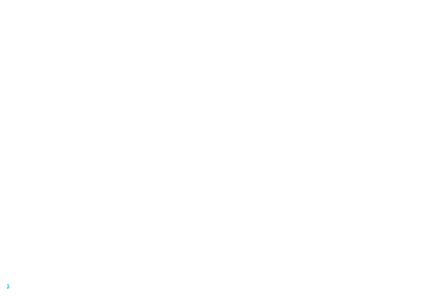

In [248]:

fig1, ax2 = plt.subplots(constrained_layout=True)

plt.xlim((0, 15))
plt.ylim((0, 12))
plt.axis('off')

show2(data_temp)


plt.show()

In [156]:
torch.norm((kstep_V_pred_ls - V_y_rel_to_abs)[:,-1,:,:],dim=2)

tensor([[0.3166],
        [0.5415],
        [0.2162],
        [0.4989],
        [0.2784],
        [0.4850],
        [0.2669],
        [0.4112],
        [0.6227],
        [0.3702],
        [0.3069],
        [0.4192],
        [0.4742],
        [0.3250],
        [0.4460],
        [0.6479],
        [0.3981],
        [0.4366],
        [0.3034],
        [0.3790]], device='cuda:7', grad_fn=<CopyBackwards>)

In [256]:
import sys
import os
import numpy as np
import pandas as pd
import dill
import pickle

from environment import Environment, Scene, Node, derivative_of

desired_max_time = 100
pred_indices = [2, 3]
state_dim = 6
frame_diff = 10
desired_frame_diff = 1
dt = 0.4

standardization = {
    'PEDESTRIAN': {
        'position': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        },
        'velocity': {
            'x': {'mean': 0, 'std': 2},
            'y': {'mean': 0, 'std': 2}
        },
        'acceleration': {
            'x': {'mean': 0, 'std': 1},
            'y': {'mean': 0, 'std': 1}
        }
    }
}

def maybe_makedirs(path_to_create):
    """This function will create a directory, unless it exists already,
    at which point the function will return.
    The exception handling is necessary as it prevents a race condition
    from occurring.
    Inputs:
        path_to_create - A string path to a directory you'd like created.
    """
    try:
        os.makedirs(path_to_create)
    except OSError:
        if not os.path.isdir(path_to_create):
            raise

def augment_scene(scene, angle):
    def rotate_pc(pc, alpha):
        M = np.array([[np.cos(alpha), -np.sin(alpha)],
                      [np.sin(alpha), np.cos(alpha)]])
        return M @ pc

    data_columns = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])

    scene_aug = Scene(timesteps=scene.timesteps, dt=scene.dt, name=scene.name)

    alpha = angle * np.pi / 180

    for node in scene.nodes:
        x = node.data.position.x.copy()
        y = node.data.position.y.copy()

        x, y = rotate_pc(np.array([x, y]), alpha)

        vx = derivative_of(x, scene.dt)
        vy = derivative_of(y, scene.dt)
        ax = derivative_of(vx, scene.dt)
        ay = derivative_of(vy, scene.dt)

        data_dict = {('position', 'x'): x,
                     ('position', 'y'): y,
                     ('velocity', 'x'): vx,
                     ('velocity', 'y'): vy,
                     ('acceleration', 'x'): ax,
                     ('acceleration', 'y'): ay}

        node_data = pd.DataFrame(data_dict, columns=data_columns)

        node = Node(node_type=node.type, node_id=node.id, data=node_data, first_timestep=node.first_timestep)

        scene_aug.nodes.append(node)
    return scene_aug


def augment(scene):
    scene_aug = np.random.choice(scene.augmented)
    scene_aug.temporal_scene_graph = scene.temporal_scene_graph
    return scene_aug


nl = 0
l = 0

data_folder_name = 'processed_data_noise'

maybe_makedirs(data_folder_name)
data_columns = pd.MultiIndex.from_product([['position', 'velocity', 'acceleration'], ['x', 'y']])


In [258]:
for desired_source in ['eth']:
    for data_class in ['test']:
        env = Environment(node_type_list=['PEDESTRIAN'], standardization=standardization)
        attention_radius = dict()
        attention_radius[(env.NodeType.PEDESTRIAN, env.NodeType.PEDESTRIAN)] = 3.0
        env.attention_radius = attention_radius

        scenes = []
        data_dict_path = os.path.join(data_folder_name, '_'.join([desired_source, data_class]) + '.pkl')

        for subdir, dirs, files in os.walk(os.path.join('raw_data', desired_source, data_class)):
            for file in files:
                if file.endswith('.txt'):
                    input_data_dict = dict()
                    full_data_path = os.path.join(subdir, file)
                    print('At', full_data_path)

                    data = pd.read_csv(full_data_path, sep='\t', index_col=False, header=None)
                    data.columns = ['frame_id', 'track_id', 'pos_x', 'pos_y']
                    data['frame_id'] = pd.to_numeric(data['frame_id'], downcast='integer')
                    data['track_id'] = pd.to_numeric(data['track_id'], downcast='integer')

                    data['frame_id'] = data['frame_id'] // 10

                    data['frame_id'] -= data['frame_id'].min()

                    data['node_type'] = 'PEDESTRIAN'
                    data['node_id'] = data['track_id'].astype(str)

                    data.sort_values('frame_id', inplace=True)

                    # ? lanni 0.6?
                    if desired_source == "eth" and data_class == "test":
                        data['pos_x'] = data['pos_x'] * 0.6
                        data['pos_y'] = data['pos_y'] * 0.6


                    data['pos_x'] = data['pos_x'] - data['pos_x'].mean()
                    data['pos_y'] = data['pos_y'] - data['pos_y'].mean()

                    max_timesteps = data['frame_id'].max()

                    scene = Scene(timesteps=max_timesteps+1, dt=dt, name=desired_source + "_" + data_class, aug_func=augment if data_class == 'train' else None)

                    for node_id in pd.unique(data['node_id']):

                        node_df = data[data['node_id'] == node_id]

                        node_values = node_df[['pos_x', 'pos_y']].values

                        if node_values.shape[0] < 2: # 节点大于2，但是包含了间断的时刻没有处理
                            continue

                        new_first_idx = node_df['frame_id'].iloc[0]

                        x = node_values[:, 0]
                        y = node_values[:, 1]
                        vx = derivative_of(x, scene.dt)
                        vy = derivative_of(y, scene.dt)
                        ax = derivative_of(vx, scene.dt)
                        ay = derivative_of(vy, scene.dt)

                        data_dict = {('position', 'x'): x,
                                     ('position', 'y'): y,
                                     ('velocity', 'x'): vx,
                                     ('velocity', 'y'): vy,
                                     ('acceleration', 'x'): ax,
                                     ('acceleration', 'y'): ay}

                        node_data = pd.DataFrame(data_dict, columns=data_columns)
                        node = Node(node_type=env.NodeType.PEDESTRIAN, node_id=node_id, data=node_data)
                        node.first_timestep = new_first_idx

                        scene.nodes.append(node)
                    if data_class == 'train':
                        scene.augmented = list()
                        angles = np.arange(0, 360, 15) if data_class == 'train' else [0]
                        for angle in angles:
                            scene.augmented.append(augment_scene(scene, angle))

                    print(scene)
                    scenes.append(scene)
        print(f'Processed {len(scenes):.2f} scene for data class {data_class}')

        env.scenes = scenes


At raw_data/eth/test/biwi_eth.txt
Scene: Duration: 464.40000000000003s, Nodes: 360, Map: No.
Processed 1.00 scene for data class test


In [259]:
data['pos_x'].mean()

3.158120538965762

In [260]:
data['pos_y'].mean()

3.188781500364173

In [70]:
import torch

# 创建一个包含3个大小为(4, 1, 2)的随机张量的列表
tensor_list = [torch.rand(4, 1, 2) for _ in range(3)]

# 创建一个目标张量，大小为(4, 1, 2)
target_tensor = torch.rand(4, 1, 2)

# 计算每个张量与目标张量之间的欧氏距离
distances = [torch.norm(target_tensor - t, dim=(1, 2)) for t in tensor_list]

# 找到最接近的索引
closest_index = torch.argmin(torch.stack(distances), dim=0)

# # 提取最接近的张量
# closest_tensor = tensor_list[closest_index]

# print("目标张量：", target_tensor)
# print("最接近的张量：", closest_tensor)

In [73]:
import torch

# Create a list of 3 tensors, each with size (4, 1, 2)
tensor_list = [torch.rand(4, 1, 2) for _ in range(3)]

# Create a target tensor with size (4, 1, 2)
target_tensor = torch.rand(4, 1, 2)

# Calculate the distances between the target tensor and tensors in the list
distances = [torch.norm(target_tensor - t, dim=(1, 2)) for t in tensor_list]

# Stack the distances to find the index of the closest tensor
stacked_distances = torch.stack(distances)
closest_index = torch.argmin(stacked_distances)

# Extract the closest tensor
closest_tensor = tensor_list[closest_index]

print("Target tensor:", target_tensor)
print("Closest tensor:", closest_tensor)

IndexError: list index out of range

In [75]:
distances

[tensor([0.1560, 0.1655, 0.2527, 0.1195]),
 tensor([0.1908, 0.9152, 0.3194, 0.3827]),
 tensor([0.3898, 0.9658, 0.2833, 0.2512])]

In [67]:
distances

[tensor([0.3896, 0.2932, 0.4947, 0.3887]),
 tensor([0.2660, 0.1295, 0.9180, 0.3591]),
 tensor([0.5160, 0.7101, 0.3941, 0.5560])]

In [76]:
import torch

def euclidean_distance(tensor1, tensor2):
    return torch.norm(tensor1 - tensor2, p=2)

# 创建表示真实坐标的张量
true_coords = torch.tensor([[1,1]],[[2,2]],[[3,3]],[[4,4]])

# 创建一个包含3次采样的张量列表
sampled_coords_list = [
   torch.tensor([[1.1,1.1]],[[21,21]],[[31,31]],[[41,41]]),
   torch.tensor([[11,11]],[[2.2,2.2]],[[31,13]],[[41,41]]),
   torch.tensor([[11,11]],[[21,21]],[[3.4,3.4]],[[41,14]]),
   torch.tensor([[11,11]],[[21,1]],[[13,31]],[[4.5,4.5]])
]

# 初始化用于存储选择的坐标的张量
selected_coords = torch.zeros_like(true_coords)

# 对于每个人，找到在所有采样中距离真实坐标最近的采样，并选择该采样
for person_index in range(true_coords.size(1)):  # 假设每个样本的维度是(1, 4, 2)
    person_true_coord = true_coords[0, person_index, :]
    min_distance = float('inf')
    nearest_sample_index = -1
    
    for sample_index, sampled_coords in enumerate(sampled_coords_list):
        distance = euclidean_distance(person_true_coord, sampled_coords[0, person_index, :])
        if distance < min_distance:
            min_distance = distance
            nearest_sample_index = sample_index
    
    selected_coords[0, person_index, :] = sampled_coords_list[nearest_sample_index][0, person_index, :]

print(selected_coords)

TypeError: tensor() takes 1 positional argument but 4 were given

In [80]:
import torch

def euclidean_distance(tensor1, tensor2):
    return torch.norm(tensor1 - tensor2, p=2)

# 创建表示真实坐标的张量
true_coords = torch.tensor([
    [[1, 1]],
    [[2, 2]],
    [[3, 3]],
    [[4, 4]]
], dtype=torch.float32)

# 创建一个包含3次采样的张量列表
sampled_coords_list = [
    torch.tensor([
        [[1.1, 1.1]],
        [[21, 21]],
        [[31, 31]],
        [[41, 41]]
    ], dtype=torch.float32),
    torch.tensor([
        [[11, 11]],
        [[2.2, 2.2]],
        [[31, 13]],
        [[41, 41]]
    ], dtype=torch.float32),
    torch.tensor([
        [[11, 11]],
        [[21, 21]],
        [[3.4, 3.4]],
        [[41, 14]]
    ], dtype=torch.float32),
    torch.tensor([
        [[11, 11]],
        [[21, 1]],
        [[13, 31]],
        [[4.5, 4.5]]
    ], dtype=torch.float32)
]

# 初始化用于存储选择的坐标的张量
selected_coords = torch.zeros_like(true_coords)

# 对于每个人，找到在所有采样中距离真实坐标最近的采样，并选择该采样
for person_index in range(true_coords.size(0)):
    person_true_coord = true_coords[person_index, :]
    min_distance = float('inf')
    nearest_sample_index = -1
    
    for sample_index, sampled_coords in enumerate(sampled_coords_list):
        distance = euclidean_distance(person_true_coord, sampled_coords[person_index, :])
        if distance < min_distance:
            min_distance = distance
            nearest_sample_index = sample_index
    
    selected_coords[person_index, :] = sampled_coords_list[nearest_sample_index][person_index, :]

print(selected_coords)


tensor([[[1.1000, 1.1000]],

        [[2.2000, 2.2000]],

        [[3.4000, 3.4000]],

        [[4.5000, 4.5000]]])


In [83]:
import torch

# 创建表示真实坐标的张量
true_coords = torch.tensor([
    [[1, 1]],
    [[2, 2]],
    [[3, 3]],
    [[4, 4]]
], dtype=torch.float32)

# 创建一个包含3次采样的张量列表
sampled_coords_list = [
    torch.tensor([
        [[1.1, 1.1]],
        [[21, 21]],
        [[31, 31]],
        [[41, 41]]
    ], dtype=torch.float32),
    torch.tensor([
        [[11, 11]],
        [[2.2, 2.2]],
        [[31, 13]],
        [[41, 41]]
    ], dtype=torch.float32),
    torch.tensor([
        [[11, 11]],
        [[21, 21]],
        [[3.4, 3.4]],
        [[41, 14]]
    ], dtype=torch.float32),
    torch.tensor([
        [[11, 11]],
        [[21, 1]],
        [[13, 31]],
        [[4.5, 4.5]]
    ], dtype=torch.float32)
]

# 转换为合并的张量，以便于进行向量化操作
sampled_coords_combined = torch.stack(sampled_coords_list)

# 计算每个采样坐标与真实坐标之间的距离
distances = torch.norm(sampled_coords_combined - true_coords, dim=2)

# 找到最小距离的索引
nearest_indices = torch.argmin(distances, dim=0)

# 根据最小距离的索引选择最近的采样坐标
# selected_coords = sampled_coords_combined[nearest_indices, torch.arange(true_coords.size(0)), :]

# print(selected_coords)


In [99]:
import torch

# 创建表示真实坐标的张量
true_coords = torch.tensor([
    [1, 1],
    [2, 2],
    [3, 3],
    [4, 4]
], dtype=torch.float32)

# 创建一个包含3次采样的张量列表
sampled_coords_list = [
    torch.tensor([
        [1.1, 1.1],
        [2.1, 1.9],
        [31, 31],
        [41, 41]
    ], dtype=torch.float32),
    torch.tensor([
        [11, 11],
        [2.2, 2.2],
        [31, 13],
        [41, 41]
    ], dtype=torch.float32),
    torch.tensor([
        [11, 11],
        [21, 21],
        [3.4, 3.4],
        [41, 14]
    ], dtype=torch.float32),
    torch.tensor([
        [11, 11],
        [21, 1],
        [13, 31],
        [4.5, 4.5]
    ], dtype=torch.float32)
]

# 转换为合并的张量，以便于进行向量化操作
sampled_coords_combined = torch.stack(sampled_coords_list)

# 计算每个采样坐标与真实坐标之间的距离
distances = torch.norm(sampled_coords_combined - true_coords[:, None, :], dim=2)

# 找到最小距离的索引
nearest_indices = torch.argmin(distances, dim=1)

# 构建索引张量以获取每个最近坐标
rows = torch.arange(true_coords.size(0))
indices = torch.stack([rows, nearest_indices], dim=1)

# 使用索引张量来获取每个最近坐标
selected_coords = torch.gather(sampled_coords_combined, 1, indices[:, None, :])

print(selected_coords.squeeze())


tensor([[1.1000, 1.1000],
        [2.2000, 2.2000],
        [3.4000, 3.4000],
        [4.5000, 4.5000]])


In [103]:
import torch

# 真实坐标
true_coords = torch.tensor([
    [1, 1],
    [2, 2],
    [3, 3],
    [4, 4]
], dtype=torch.float32)

# 采样坐标列表
sampled_coords_list = [
    torch.tensor([
        [1.1, 1.1],
        [2.1, 1.9],
        [31, 31],
        [41, 41]
    ], dtype=torch.float32),
    torch.tensor([
        [11, 11],
        [2.2, 2.2],
        [31, 13],
        [41, 41]
    ], dtype=torch.float32),
    torch.tensor([
        [11, 11],
        [21, 21],
        [3.4, 3.4],
        [4.4, 4.4]
    ], dtype=torch.float32)
]

# 将采样坐标列表转换为张量
sampled_coords_tensor = torch.stack(sampled_coords_list)

# 计算每个采样坐标与真实坐标之间的距离
distances = torch.cdist(sampled_coords_tensor, true_coords)

# 找到每个采样坐标最接近的真实坐标索引
closest_indices = torch.argmin(distances, dim=1)

# 使用索引获取最接近的真实坐标
closest_coords = torch.stack([true_coords[i] for i in closest_indices])

print(closest_coords)


tensor([[[1., 1.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[3., 3.],
         [3., 3.],
         [3., 3.],
         [4., 4.]]])


In [104]:
import torch

# 真实坐标
true_coords = torch.tensor([
    [1, 1],
    [2, 2],
    [3, 3],
    [4, 4]
], dtype=torch.float32)

# 采样坐标列表
sampled_coords_list = [
    torch.tensor([
        [1.1, 1.1],
        [2.1, 1.9],
        [31, 31],
        [41, 41]
    ], dtype=torch.float32),
    torch.tensor([
        [11, 11],
        [2.2, 2.2],
        [31, 13],
        [41, 41]
    ], dtype=torch.float32),
    torch.tensor([
        [11, 11],
        [21, 21],
        [3.4, 3.4],
        [4.4, 4.4]
    ], dtype=torch.float32)
]

# 将采样坐标列表转换为张量
sampled_coords_tensor = torch.stack(sampled_coords_list)

# 计算每个采样坐标与真实坐标之间的距离
distances = torch.cdist(sampled_coords_tensor, true_coords)

# 找到每个采样坐标最接近的真实坐标索引
closest_indices = torch.argmin(distances, dim=1)

# 使用索引获取最接近的真实坐标
closest_coords = true_coords[closest_indices]

print(closest_coords)


tensor([[[1., 1.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]],

        [[3., 3.],
         [3., 3.],
         [3., 3.],
         [4., 4.]]])


In [105]:
distances

tensor([[[ 0.1414,  1.2728,  2.6870,  4.1012],
         [ 1.4213,  0.1414,  1.4213,  2.8320],
         [42.4264, 41.0122, 39.5980, 38.1838],
         [56.5685, 55.1543, 53.7401, 52.3259]],

        [[14.1421, 12.7279, 11.3137,  9.8995],
         [ 1.6971,  0.2828,  1.1314,  2.5456],
         [32.3110, 31.0161, 29.7321, 28.4605],
         [56.5685, 55.1543, 53.7401, 52.3259]],

        [[14.1421, 12.7279, 11.3137,  9.8995],
         [28.2843, 26.8701, 25.4558, 24.0416],
         [ 3.3941,  1.9799,  0.5657,  0.8485],
         [ 4.8083,  3.3941,  1.9799,  0.5657]]])

In [106]:
sampled_coords_tensor.size()

torch.Size([3, 4, 2])

In [111]:
torch.norm((sampled_coords_tensor- true_coords),dim=-1)

tensor([[ 0.1414,  0.1414, 39.5980, 52.3259],
        [14.1421,  0.2828, 29.7321, 52.3259],
        [14.1421, 26.8701,  0.5657,  0.5657]])

In [178]:
indices=torch.min(torch.norm((sampled_coords_tensor- true_coords),dim=-1),dim=0)[1]

In [179]:
indices

tensor([0, 0, 2, 2])

In [182]:
index=torch.tensor([[0,0], [0,0], [2,2], [2,2]])

In [186]:
index.size()

torch.Size([4, 2])

In [188]:
sampled_coords_tensor.size()

torch.Size([4, 2])

In [189]:
torch.gather(sampled_coords_tensor,0,index)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [136]:
sampled_coords_tensor.size()

torch.Size([3, 4, 2])

In [171]:
sampled_coords_tensor

tensor([[[ 1.1000,  1.1000],
         [ 2.1000,  1.9000],
         [31.0000, 31.0000],
         [41.0000, 41.0000]],

        [[11.0000, 11.0000],
         [ 2.2000,  2.2000],
         [31.0000, 13.0000],
         [41.0000, 41.0000]],

        [[11.0000, 11.0000],
         [21.0000, 21.0000],
         [ 3.4000,  3.4000],
         [ 4.4000,  4.4000]]])

In [131]:
torch.tensor([[0, 0, 2, 2],[0, 0, 2, 2]])

tensor([[0, 0, 2, 2],
        [0, 0, 2, 2]])

In [135]:
torch.gather(sampled_coords_tensor,1,torch.tensor([[0, 0, 2, 2]]))

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [31]:
import torch

# Given tensors
sampled_coords_tensor = torch.tensor([[[1.1000, 1.1000],
                                      [2.1000, 1.9000],
                                      [31.0000, 31.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [2.2000, 2.2000],
                                      [31.0000, 13.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [21.0000, 21.0000],
                                      [3.4000, 3.4000],
                                      [4.4000, 4.4000]]])
target= torch.tensor([[[1.000, 1.000],
                                      [2.000, 2.000],
                                      [3.0000, 3.0000],
                                      [4.0000, 4.0000]]])
# index = torch.tensor([0, 0, 2, 2])

# # Select coordinates using index
# output_coords = sampled_coords_tensor[torch.arange(sampled_coords_tensor.size(0)), index]

# print(output_coords)


In [84]:
target.size()

torch.Size([1, 4, 2])

In [81]:
# 转换为合并的张量，以便于进行向量化操作
# sampled_coords_combined = torch.stack(sampled_coords_tensor)

# 计算每个采样坐标与真实坐标之间的距离
distances = torch.norm(sampled_coords_tensor - target, dim=2)

# 找到最小距离的索引
nearest_indices = torch.argmin(distances, dim=0)

# # 构建索引张量以获取每个最近坐标
rows = torch.arange(target.size(1))
# indices = torch.stack([nearest_indices,rows], dim=1)

selected_values = sampled_coords_tensor[nearest_indices, rows]

selected_tensor = selected_values.view(-1, 2)

# # 使用索引张量来获取每个最近坐标
# selected_coords = torch.gather(sampled_coords_combined, 1, indices[:, None, :])

# print(selected_coords.squeeze())

In [82]:
selected_tensor

tensor([[1.1000, 1.1000],
        [2.1000, 1.9000],
        [3.4000, 3.4000],
        [4.4000, 4.4000]])

In [69]:
indices

tensor([[0, 0],
        [0, 1],
        [2, 2],
        [2, 3]])

In [76]:
torch.select(sampled_coords_tensor, 1,indices)

TypeError: select() received an invalid combination of arguments - got (Tensor, int, Tensor), but expected one of:
 * (Tensor input, int dim, int index)
      didn't match because some of the arguments have invalid types: (Tensor, int, !Tensor!)
 * (Tensor input, name dim, int index)
      didn't match because some of the arguments have invalid types: (Tensor, !int!, !Tensor!)


In [63]:
sampled_coords_tensor[0,1]tensor([[1.1000, 1.1000],[2.1000, 1.9000],[3.4000, 3.4000][4.4000, 4.4000]])

tensor([2.1000, 1.9000])

In [79]:
selected_values = sampled_coords_tensor[indices[:, 0], indices[:, 1]]

selected_tensor = selected_values.view(-1, 2)

In [80]:
selected_tensor

tensor([[1.1000, 1.1000],
        [2.1000, 1.9000],
        [3.4000, 3.4000],
        [4.4000, 4.4000]])

In [78]:
sampled_coords_tensor[0,0]

tensor([1.1000, 1.1000])

In [60]:
sampled_coords_tensor[2,3]

tensor([4.4000, 4.4000])

In [26]:
closest_indices

tensor([[0, 1, 1, 1],
        [1, 1, 1, 1],
        [2, 2, 2, 3]])

In [21]:
        # 用来存储每个item的采样概率
        sampling_probs = []

        # 计算每个item与第一个tensor的采样概率
        for coordinates_tensor in sampled_coords_tensor:

            # 计算该item在第一个分布下的log概率之和
            # log_prob_sum = gauss_distribution.log_prob(coordinates_tensor).sum()
            fde=torch.norm((coordinates_tensor.reshape(4, 2) - target.reshape(4, 2)),dim=1)

            # 将采样概率存储到列表中
            sampling_probs.append(fde)

        # 找到具有最大采样概率的item的索引
        max_prob_index = torch.argmin(torch.stack(sampling_probs),dim=0)

        # # 选取最有可能是由第一个tensor采样得到的item
        selected_tensor = sampled_coords_tensor[max_prob_index]
        # selected_sampling_probs= sampling_probs[max_prob_index]

In [23]:
max_prob_index

tensor([0, 0, 2, 2])

In [141]:
import torch

# Given tensors
sampled_coords_tensor = torch.tensor([[[1.1000, 1.1000],
                                      [2.1000, 1.9000],
                                      [31.0000, 31.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [2.2000, 2.2000],
                                      [31.0000, 13.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [21.0000, 21.0000],
                                      [3.4000, 3.4000],
                                      [4.4000, 4.4000]]])

index = torch.tensor([0, 0, 2, 2])

# Select coordinates using index
output_coords = sampled_coords_tensor[torch.arange(sampled_coords_tensor.size(0)), index]

print(output_coords)


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [3], [4]

In [153]:
import torch

# Given tensors
sampled_coords_tensor = torch.tensor([[[1.1000, 1.1000],
                                      [2.1000, 1.9000],
                                      [31.0000, 31.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [2.2000, 2.2000],
                                      [31.0000, 13.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [21.0000, 21.0000],
                                      [3.4000, 3.4000],
                                      [4.4000, 4.4000]]])

index = torch.tensor([0, 0, 2, 2],[0, 0, 2, 2],[0, 0, 2, 2])
# Select coordinates using index
output_coords = sampled_coords_tensor[torch.arange(sampled_coords_tensor.size(0)), index]

print(output_coords)


TypeError: tensor() takes 1 positional argument but 3 were given

In [157]:
torch.gather(sampled_coords_tensor.permute(1,0,2),0,index)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [162]:
index=torch.tensor([0, 0, 2, 2])

In [167]:
sampled_coords_tensor

tensor([[[ 1.1000,  1.1000],
         [ 2.1000,  1.9000],
         [31.0000, 31.0000],
         [41.0000, 41.0000]],

        [[11.0000, 11.0000],
         [ 2.2000,  2.2000],
         [31.0000, 13.0000],
         [41.0000, 41.0000]],

        [[11.0000, 11.0000],
         [21.0000, 21.0000],
         [ 3.4000,  3.4000],
         [ 4.4000,  4.4000]]])

In [170]:
import torch

# Given tensors
sampled_coords_tensor = torch.tensor([[[1.1000, 1.1000],
                                      [2.1000, 1.9000],
                                      [31.0000, 31.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [2.2000, 2.2000],
                                      [31.0000, 13.0000],
                                      [41.0000, 41.0000]],
                                     
                                     [[11.0000, 11.0000],
                                      [21.0000, 21.0000],
                                      [3.4000, 3.4000],
                                      [4.4000, 4.4000]]])

index = torch.tensor([0, 0, 2, 2])

# Prepare row indices for gather
row_indices = torch.arange(sampled_coords_tensor.size(0)).unsqueeze(1).unsqueeze(2)

# Expand index tensor to match the shape of sampled_coords_tensor
expanded_index = index.unsqueeze(1).unsqueeze(2).expand(-1, sampled_coords_tensor.shape[1], 2)

# Combine row indices and expanded index tensor
combined_indices = torch.cat([row_indices, expanded_index], dim=2)

# Select coordinates using gather
output_coords = torch.gather(sampled_coords_tensor, 1, combined_indices)

print(output_coords.squeeze())


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 3 but got size 4 for tensor number 1 in the list.

In [190]:
    row_indices, col_indices = index[:, 0], index[:, 1]
    selected_coords = torch.gather(sampled_coords_tensor, 1, col_indices.view(-1, 1))


RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [192]:
index = torch.tensor([0, 0, 2, 2])

In [194]:
sampled_coords_tensor.shape[1]

4

In [196]:
index.expand(-1, sampled_coords_tensor.shape[1], 2)

RuntimeError: The expanded size of the tensor (2) must match the existing size (4) at non-singleton dimension 2.  Target sizes: [-1, 4, 2].  Tensor sizes: [4]

In [197]:
    # 将索引张量扩展为合适的形状，以便与 sampled_coords_tensor 匹配
    expanded_index = index.expand(1, sampled_coords_tensor.shape[1], 2)
    
    # 使用 gather 函数从 sampled_coords_tensor 中收集坐标
    gathered_coords = torch.gather(sampled_coords_tensor, 0, expanded_index)
    
    # 去除不必要的维度，输出最终的坐标张量
    gathered_coords = gathered_coords.squeeze(dim=0)

RuntimeError: The expanded size of the tensor (2) must match the existing size (4) at non-singleton dimension 2.  Target sizes: [1, 4, 2].  Tensor sizes: [4]

In [200]:
index

tensor([0, 0, 2, 2])

In [204]:
sampled_coords_tensor

tensor([[[ 1.1000,  1.1000],
         [ 2.1000,  1.9000],
         [31.0000, 31.0000],
         [41.0000, 41.0000]],

        [[11.0000, 11.0000],
         [ 2.2000,  2.2000],
         [31.0000, 13.0000],
         [41.0000, 41.0000]],

        [[11.0000, 11.0000],
         [21.0000, 21.0000],
         [ 3.4000,  3.4000],
         [ 4.4000,  4.4000]]])

In [205]:
index

tensor([0, 0, 2, 2])

In [207]:
torch.index_select(sampled_coords_tensor, 0, index)

tensor([[[ 1.1000,  1.1000],
         [ 2.1000,  1.9000],
         [31.0000, 31.0000],
         [41.0000, 41.0000]],

        [[ 1.1000,  1.1000],
         [ 2.1000,  1.9000],
         [31.0000, 31.0000],
         [41.0000, 41.0000]],

        [[11.0000, 11.0000],
         [21.0000, 21.0000],
         [ 3.4000,  3.4000],
         [ 4.4000,  4.4000]],

        [[11.0000, 11.0000],
         [21.0000, 21.0000],
         [ 3.4000,  3.4000],
         [ 4.4000,  4.4000]]])